# 1. Problem Statement 

* Since the outbreak of COVID-19, found an overwhelming number of papers on the topic have been published from across the world. As per the dataset under consideration, there are 51,000 scholarly articles already published about COVID-19, SARS-CoV-2, and related coronaviruses. 
* There might be bits of information scattered across this huge dataset that may be pieces of puzzle that will help a medical researcher or a pharmaceutical organization to find cure or vaccine.
* Unfortunately, its humanely impossible to scan this enormous data and to make matters worse thousands might be getting added every week. 
* In conclusion, unless an efficient method is developed that helps a team to make sense of this growing data, valuable time will be wasted on repeated research’s.

# 2. Solution  

* The solution being proposed as part of submission is to build an unsupervised learning that help match research papers relevancy corresponding to question being asked. 
* The solution uses “doc2vec” algorithm that will assign numeric representation to documents in response to questions being posed to the model. 
* The questions themselves are grouped in paragraphs with one paragraph representing a single theme such as transmission, incubation, etc. 
* The response is presented in three stages – 
* Word Map – this map highlights the most found words in the document’s dataset in response to the question being asked. The emphasis of the words depends on their frequency present in the answer to the question.
* Answer to the question – the answer section essentially performs a text mining task taking the question paragraph as input and running against the research papers in the data set. It lists all the sentences within the papers present in the data which as per AI represents the closest proximity to the question being answered.
* 	List of Research Paper – the final stage of response is list of research papers sorted on the rank that will assist a researcher to narrow the papers to look for in response to questions posted. The ranking is again based on closest proximity of the research paper to the question set posted. 

# 3.Schematic of the Solution 

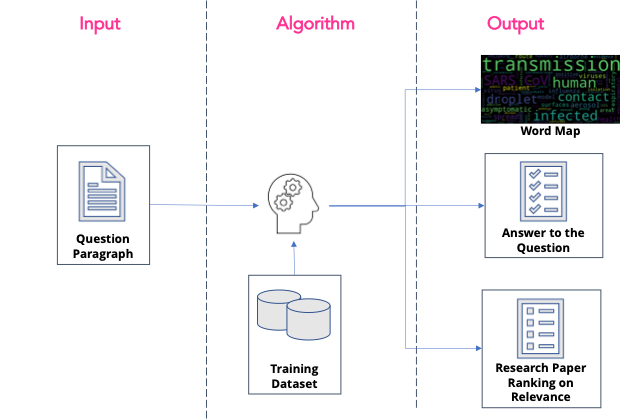

# Importing Dataset

The first step is to import the json dataset and extract the relevant details viz. 
* Document Title, 
* File Name 
* Research Text (stored under body_text)

In [ ]:
import json 
import pandas as pd 
import os
from pathlib import Path
from pandas.io.json import json_normalize 

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

base_dir is the base location of whole dataset.
Just by configuring the required data folders in dir_list, the model can be pointed to train and execute on the given set of folders.
The code will extract all the files with .json extension under the given folder list.

The model has been tested with three combination of folders.
1. biorxiv_medrxiv
2. biorxiv_medrxiv,noncomm_use_subset
3. biorxiv_medrxiv,noncomm_use_subset,comm_use_subset

Due to time constraints in tuning and building the correct doc2vec model, test with combination of all 4 folders(i.e. biorxiv_medrxiv,noncomm_use_subset,comm_use_subset,custom_license ) has not been performed in this research.

In [ ]:
base_dir='/kaggle/input/CORD-19-research-challenge/'
dir_list = ['biorxiv_medrxiv','noncomm_use_subset']

In [ ]:
raw_documents=[]
documents_name=[]
title_name=[]
doc_df=pd.DataFrame()

def getTextFromJSON(d):     
    try:
        bodytext_df = json_normalize(d['body_text'])
        body_text_list = bodytext_df['text'].tolist()
    except KeyError:
        body_text_list=[]
        
    title_df = json_normalize(d['metadata'])
    title = title_df['title'][0]

    return {'body':body_text_list,'title':title};
    
def pouplateRawDocumentsFromFiles(directory_in_str):
    pathlist = Path(directory_in_str).glob('**/*.json')
    for path in pathlist:
        path_in_str = str(path)
        f = open(path_in_str)
        d = json.load(f)
        raw_documents.append(getTextFromJSON(d)['body'])
        title_name.append(getTextFromJSON(d)['title'])
        documents_name.append(path_in_str)
    return ;

def loadData():     
    for directory in dir_list:
        pouplateRawDocumentsFromFiles(base_dir+directory)

    doc_df['doc_content']=raw_documents
    doc_df['doc_name']=documents_name
    doc_df['doc_title']=title_name


In [ ]:
loadData()

In [ ]:
print('The total number of files from folder(s) '+str(dir_list)+ ' are: '+str(len(raw_documents)))

# Data Cleansing
* The dataset contains many duplicate files with same title and body texts. However, each paper has a unique paper id.
* This causes problems in training of the model as well as gives duplicate results. Hence, files have been filtered based on uniqueness of the paper titles.

In [ ]:
doc_df.drop_duplicates(subset ="doc_title", keep = False, inplace = True) 
print('The total number of files after removing duplicate files from folder(s) '+str(dir_list)+ ' are: '+str(len(doc_df)))

Based on the document word profiling, below are the noise words which hold very little value in determining accurate results.
Hence, such words have been discared in model consideration.

In [ ]:
stop_words = stopwords.words('english')
stop_words.extend(['copyright','peer','holder','preprint','author','funder','https','doi','org','reviewed',
                    'bioRxiv','et','found','sought','wondered','reserved','rights','reuse',
                    'permission','allowed','without','right','using','http','although','create','however',
                    'cc','by','license','biorxiv','medrxiv','fig','http','1101','et','al','figure',
                    'nc','nd','4','0','international','made','available','under','for','this',
                    'preprint','which','was','not','10','2020','01','30','927574','ma','02','03',
                    'could','non','within','il','three','value','shown','pcr','rnl','ml','min','mm','new','would',
                    'related','thus','per','site','like','known','may','also','used','know','e','g','settings','usefulness'])

* The input dataset set before model training is cleansed by doing the text preporcessing. 
* The preprocessing of text data includes removal of special characters, numbers, single digit characters, multiple spaces. 
* Post that text is converted to lowercase to mitigate the case sensitivity. 
* Finally, the text is lemmatized so that all the different forms of same words can be converged to a single word. 

In [ ]:
def getPreProcessesText(raw_text_str):
    lemmatizer = WordNetLemmatizer()

    # Remove all the special characters
    cleansed_text_str = re.sub(r'\W', ' ', raw_text_str)
    # Remove numbers 
    cleansed_text_str = re.sub(r' \d+ ', ' ', cleansed_text_str)
    # Remove all single characters
    cleansed_text_str = re.sub(r'\s+[a-zA-Z]\s+', ' ', cleansed_text_str)
    # Remove single characters from the start
    cleansed_text_str = re.sub(r'\^[a-zA-Z]\s+', ' ', cleansed_text_str) 
    # Substituting multiple spaces with single space
    cleansed_text_str = re.sub(r'\s+', ' ', cleansed_text_str, flags=re.I)
    # Converting to Lowercase
    cleansed_text_str = cleansed_text_str.lower()

    # Lemmatization
    cleansed_text_list = cleansed_text_str.split()
    lemmatized_text_list = [lemmatizer.lemmatize(word) for word in cleansed_text_list]
    lemmatized_text_stopped_list = [word for word in lemmatized_text_list if word not in stop_words]
    preprocessed_text_str = ' '.join(lemmatized_text_stopped_list)
    return preprocessed_text_str 

Below is the task decription of first task which is the scope for this submission i.e.
* **What is known about transmission, incubation, and environmental stability?**


In [ ]:
task1="What is known about transmission, incubation, and environmental stability?\
What do we know about natural history, transmission, and diagnostics for the virus?\
What have we learned about infection prevention and control?\
Range of incubation periods for the disease in humans (and how this varies across age and health status)\
and how long individuals are contagious, even after recovery.\
Prevalence of asymptomatic shedding and transmission (e.g., particularly children).\
Seasonality of virus transmission and virus spread.\
Physical science of the coronavirus (e.g., charge distribution, adhesion to hydrophilic/phobic surfaces, \
environmental survival to inform decontamination efforts for affected areas and \
provide information about viral shedding).\
Persistence and stability on a multitude of substrates and sources \
(e.g., nasal discharge, sputum, urine, fecal matter, blood).\
Persistence of virus on surfaces of different materials (e,g., copper, stainless steel, plastic).\
Natural history of the virus and shedding of it from an infected person.\
Implementation of diagnostics and products to improve clinical processes.\
Disease models, including animal models for infection, disease and transmission.\
Tools and studies to monitor phenotypic change and potential adaptation of the virus.\
Immune response and immunity.\
Effectiveness of movement control strategies to prevent secondary transmission in health care and community settings.\
Effectiveness of personal protective equipment (PPE) and \
its usefulness to reduce risk of transmission in health care and community settings.\
Role of the environment in transmission."

In [ ]:
from nltk.tokenize import word_tokenize
import gensim.models.phrases
from nltk import ngrams

def getBiGramList(sentence):
    biGramList=[]
    for grams in ngrams(sentence.split(), 2):
        if grams[0] not in stop_words:
            biGramList.append(grams[0]+' '+grams[1])
    return biGramList;

In [ ]:
raw_para_documents=[]
raw_para_doc_name=[]
raw_para_doc_title=[]
para_df=pd.DataFrame()

# Defining the boundary of a document for doc2vec 
There are 3 options which have been considered for the doc2vec model. The options are based on defining the boundary of a document for training model.
1. A sentence is a doc
2. A paragraph is a doc **(selected)**
3. A full file text is a doc.

**Option2** from the above list is selected as the most preffered option for this solution.
Resons are:
* A paragraph is a number of sentences grouped together and relating to one context. Or, a group of related sentences that develop a single point. 
* Hence it represents the context better whereas a sentence has a very less context for the information and a full document contains tens or hunderds of points/contexts.
* As the most similar documents are predicted by the doc2vec model based on the vector similarity of the query/question text. 
* In this case, the questions which are asked from the model are in form of sentences 
* e.g. "What is known about incubation? How long is the incubation period in patients for covid,sars and mers virus in days? Range of incubation periods for the disease in humans? How the incubation period varies across age, health status? How long individuals are contagious, even after recovery?". 
* Since, the question itself is asked in form of a paragraph, the best chance of getting accurate match is to match the paragraph from the documents instead of snetence or paragraph.

SO, FOR TRAINING DOC2VEC MODEL, EACH PARAGRAPH WILL BE CONSIDERED AS ONE DOC i.e. every paragraph is represented as vector.

The lineage of each paragraph is maintained, i.e. to which filename the paragraph belongs and title of the document is maintained throughout so that it can be published in final answer.

# Extracting dataset required for the task
* Based on the document paragraph profiling, there were many paragraphs which were smaller in length and contained lot of noise. To overcome this issue, a minimum valid paragraph length is configured as 190 for optimum results.
* Considering the 'garbage in garbage out' philosophy, it is imperative to ***not*** consider noisy paragraphs. For doing so, a whitelist has been configured with the bigrams extracted from the task descritpion and some important unigrams which are relevant to the task at hand. Based, on these whitelist and a blacklist to remove know garbage, the paragraphs are selected to train the model.


In [ ]:
BIGRAM_WHITE_LIST=getBiGramList(getPreProcessesText(task1))
UNIGRAM_WHITE_LIST=['surfaces','asymptomatic','contagious']
DOC_WHITE_LIST=UNIGRAM_WHITE_LIST+BIGRAM_WHITE_LIST
DOC_BLACK_LIST=['The copyright holder for this preprint']

VALID_PARAGRAPH_MIN_LENGHT=190

def doesParagraphContainAnyOfListNGrams(paragraph,selectionList):
    isPresent=False;
    for part in selectionList:
        if part.lower() in paragraph.lower():
            isPresent=True; 
            break;
    return isPresent;

def isParagraphLengthValid(paragraph):
    return len(paragraph)>=VALID_PARAGRAPH_MIN_LENGHT;

def populateRawParagraphsFromRawDocs():
    for index, row in doc_df.iterrows():      
        for paragraph in row['doc_content']: 
            if isParagraphLengthValid(paragraph):
                if doesParagraphContainAnyOfListNGrams(paragraph, DOC_WHITE_LIST) and not doesParagraphContainAnyOfListNGrams(paragraph, DOC_BLACK_LIST): 
                    raw_para_documents.append(paragraph)
                    raw_para_doc_name.append(row['doc_name'])
                    raw_para_doc_title.append(row['doc_title'])
    return;

In [ ]:
populateRawParagraphsFromRawDocs()
print(len(raw_para_documents))
print('The total number of paragraphs for model training from folder(s) '+str(dir_list)+ ' are: '+str(len(raw_para_documents)))

In [ ]:
para_df['para_content']=raw_para_documents
para_df['doc_name']=raw_para_doc_name
para_df['doc_title']=raw_para_doc_title

* Below is the wrapper function to do all the above mentioned tasks on each file's raw text and obtain a document list which contains the de-duplicated, valid, relevant, cleansed and lemmatized paragraph text as outcome. 
This outcome is fed to doc2vec model.

In [ ]:
documents=[]

def pouplateDocumentsFromFiles():
    for raw_document in raw_para_documents:
        documents.append(getPreProcessesText(raw_document))
    
pouplateDocumentsFromFiles()
print(len(documents))

# Train Doc2vec Model
The doc2vec model is trained using the parameters(dm=0, vector_size=300, min_count=1, epochs=30).

A testing code (written in last few cells of the notebook) is used to measure the outcomes of the trained model and decide on the tuning parameters of the model.(In Last Section - Test Model Consistency and Matching Accuracy for tuning model)

The two main things considered across the various attempts of model training were
1. consistency of results
2. average matching score 

The doc2vec model was initially trained by manually providing the learning rates, then by directly training doc2vec with various configurations like varying ecpoch,dm, min_count, window size etc.
The best combination was observed with below parameters. 

1. The selected model has average consistency in results across model attempts as approx 80% (with all values lying in close proximity) 

2. Average best matching score approx. 0.67(again with all values lying in close proximity).
The tests are done with random question text inputs.

In [ ]:
def trainDoc2Vec(tagged_data):
    model=Doc2Vec(dm=0, vector_size=300, min_count=1, epochs=30, workers=16)
    model.build_vocab(tagged_data)
    model.train(tagged_data,total_examples=model.corpus_count,epochs=model.epochs)

    model.save("d2vBodyCovid.model")
    print("Model Saved")
    return model;

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(documents)]

In [ ]:
trainDoc2Vec(tagged_data)

# Ask Questions to the Model

In [ ]:
from gensim.models.doc2vec import Doc2Vec

model= Doc2Vec.load("d2vBodyCovid.model")

transmissionQuery="What is known about transmission?\
Is the virus transmitted by aerosol, droplets, food, close contact, fecal matter, or water?\
Prevalence of asymptomatic shedding and virus transmission?\
How does weather, heat, and humidity affect the tramsmission of 2019-nCoV?\
Seasonality of virus transmission and virus spread?\
Disease models, including animal models for infection, disease and transmission?"

incubationPeriodQuery="What is known about incubation?\
How long is the incubation period in patients for covid,sars and mers virus in days?\
Range of incubation periods for the disease in humans ?\
How the incubation period varies across age, health status?\
How long individuals are contagious, even after recovery?"

environmentalStabilityPeriodQuery="What is known about environmental stability?\
How long can the 2019-nCoV virus remain viable on common surfaces?\
What is known about charge distribution, adhesion to hydrophilic/phobic surfaces?\
What is the environmental survival to inform decontamination efforts for affected areas \
and provide information about viral shedding?\
What do we know about physical science of the coronavirus?"

diseaseQuery="What is known about diseases, symptoms associated with covid,sars,mers?\
What has been published about medical care?\
What do we know about vaccines and therapeutics"

preventionQuery="What is the immune system response to 2019-nCoV?\
Can 2019-nCoV infect patients a second time?\
Effectiveness of movement control strategies to prevent secondary transmission\
in health care and community settings?\
Effectiveness of personal protective equipment (PPE) and \
its usefulness to reduce risk of transmission in health care and community settings?"

questions=[transmissionQuery,incubationPeriodQuery,environmentalStabilityPeriodQuery,diseaseQuery,preventionQuery]

# Deduce the final answer

In [ ]:
NUM_OF_PARAGRAPHS_TO_PICK=60
NUM_OF_PARAGRAPHS_TO_SUMMARIZE=30
DOC_SUMMARY_RATIO=0.50

In [ ]:
from gensim.summarization.summarizer import summarize 
from gensim.summarization import keywords 

def getDocFileName(doc_tuple):
    return para_df['doc_name'].tolist()[int(doc_tuple[0])];

def getDocTitle(doc_tuple):
    return para_df['doc_title'].tolist()[int(doc_tuple[0])];

def getRelevantLiterature(similarDoc,numOfParagraphs):
    doc_count=0
    search_result_docs=[]
    search_result_titles=[]
    result_df=pd.DataFrame()
    for doc_tuple in similarDoc:  
        if doc_count < numOfParagraphs:
            search_result_docs.append(getDocFileName(doc_tuple))
            search_result_titles.append(getDocTitle(doc_tuple))
        doc_count=doc_count+1
    result_df['doc_name']=search_result_docs
    result_df['doc_title']=search_result_titles
    result_df.drop_duplicates(subset ="doc_name", keep = False, inplace = True) 
    return result_df;

def getRelevantDocsWithSummary(doc_tuple):
    relevant_doc=""
    docText=raw_para_documents[int(doc_tuple[0])]
    try:
        summary=summarize(docText, ratio=DOC_SUMMARY_RATIO)
        if len(summary)>0:
            relevant_doc=summary
        else:
            relevant_doc=docText
    except:
        relevant_doc=docText
    return relevant_doc;

def classifyDocs(similarDoc,numOfParagraphs):
    doc_count=0
    relevant_docs=[]
    other_docs=[]
    for doc_tuple in similarDoc:  
        if doc_count < numOfParagraphs:
            relevant_doc=getRelevantDocsWithSummary(doc_tuple)
            relevant_docs.append(relevant_doc) 
        else:
            other_docs.append(raw_para_documents[int(doc_tuple[0])])
        doc_count=doc_count+1
    return {'relevant_docs':relevant_docs,'other_docs':other_docs};
 
def getFinalSummary(relevant_docs):
    summary_str=''
    for summary in relevant_docs:
        summary_str = summary_str+' '+summary
    summary = summarize(summary_str, ratio = DOC_SUMMARY_RATIO) 
    return summary;
    
def getAnswer(question):    
    questionVector = model.infer_vector(word_tokenize(getPreProcessesText(question)))
    similar_doc = model.docvecs.most_similar([questionVector],topn=NUM_OF_PARAGRAPHS_TO_PICK)
    classified_docs=classifyDocs(similar_doc,NUM_OF_PARAGRAPHS_TO_SUMMARIZE)
    return {'result_summary':getFinalSummary(classified_docs['relevant_docs']),
            'result_literature':getRelevantLiterature(similar_doc,NUM_OF_PARAGRAPHS_TO_SUMMARIZE)}

def getClassifiedDocs(question):    
    questionVector = model.infer_vector(word_tokenize(getPreProcessesText(question)))
    similar_doc = model.docvecs.most_similar([questionVector],topn=NUM_OF_PARAGRAPHS_TO_PICK)
    classified_docs=classifyDocs(similar_doc,NUM_OF_PARAGRAPHS_TO_SUMMARIZE)
    return classified_docs;
    

# See the Results!!


## How to interpret the result wrt to the task.

* We will cover all aspects of transmission , incubation and environmental stability of the virus as required by the task.

  1. A question will be displayed first.
  2. To arrive at the answer to the question asked,  
  3. At the very high level the approach is that:
  
*  Doc2vec model is built using the paragraphs extracted from relevant documents classified basis the task query.
*  The similarity is computed between the query vector and the individual paragraph vectors.
*  The model outputs the ranked similarity score of each of the paragraph vector against the query vector.
*  Paragraphs with top 30 similarity  score are picked.
*  To help with some insights ,individual summaries using the Gensim Sumarize which used the page ranking technique.
*  To arrive at an optimum summary percentage ratio, tests were conducted with varied ratios,thereby 50% summary percent ratio was decided.
*  The individual paragraph summary is finally summarised to answer some of the key parts of the question.
*  Summary helps get a good gist of what the result looks like and gauge the result content satisfaction based on the query.  

    4. The word cloud displayed is a quick representation ,to validate the result by looking at the top words . Idea is to have the top words as close to the context of question as possible.
    5. This final summary is printed and it also highlights the key parts of the question which help getting a  quick perception of the result .
    6. Furthermore as per the task requirement the outcome also consists of the list of documents  used the extract the above results.The list of these documents shown with the title of the document and the filename is ranked basis the closeness to the answer.Formore information these documents can be used for reference.

In [ ]:
from termcolor import colored
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

def showWordCloud(data,stop_words):
    mpl.rcParams['font.size']=12                
    mpl.rcParams['savefig.dpi']=100             
    mpl.rcParams['figure.subplot.bottom']=.1 

    stopwords = set(stop_words)
    wordcloud_text_str=data

    wordcloud = WordCloud(background_color='black',
                            stopwords=stopwords,
                            max_words=100,
                            max_font_size=60, 
                            random_state=42
                            ).generate(wordcloud_text_str)

    fig = plt.figure(1)
    plt.imshow(wordcloud)
    plt.axis('off') 
    plt.show()
    return;

In [ ]:
import sys 
from termcolor import colored, cprint 

def printColored(text):
    print(colored(text, 'red', attrs=['reverse', 'blink']))
    
def printColoredDfRow(text):
    print(colored(text, 'blue', attrs=['reverse', 'blink']))
    
def getHighlightedtext(text,highlightList):
    return " ".join(colored(t,'white','on_green') if getPreProcessesText(t) in highlightList else t for t in text.split())

def displayResultDf(resultDf):
    for index, row in resultDf.iterrows(): 
        printColoredDfRow(str(index+1)+'. '+row['doc_title'])
        print(row['doc_name'])

In [ ]:
def seeTheResults(questions):
    for question in questions:
        printColored("===========================QUESTION================================")
        print(question)
        printColored("\n\n==================HIGHLIGHTS OF SEARCH RESULT======================")
        showWordCloud(getAnswer(question)['result_summary'],stop_words)
        printColored("=====================ANSWER OF QUESTION============================")
        print(getHighlightedtext(getAnswer(question)['result_summary'],word_tokenize(getPreProcessesText(question))))
        printColored("\n\n============MOST RELEVANT LITERATURE [TITLE(NAME)]=================")
        displayResultDf(getAnswer(question)['result_literature'])
        printColored("\n======================RESULT COMPLETED=============================")
        print('\n' * 2)
    return;

In [ ]:
seeTheResults(questions)

# *How Close are we with the results?*
* The closeness of the results to the question is depicted using a t-SNE visualisation .
* The graph is plotted using the below vectors
  1. Doc Vectors - Vector represented by individual paragraphs. The vector labels have been classified to mark the top 30 matches as results(e.g. result1) and remaining as docs(e.g. d1).
  2. Query Vector - Vector is formed by the question/ query text.

For e.g.  let us look at results wrt incubation queriesEach visualisation is shown with a different perplexity.

The graphs indicate that all the selected results vectors are near to the query/question vector in at least one perplexity.

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def getVecsAndLabels(query):
    vecs=[]
    labels=[]

    taskVector = model.infer_vector(word_tokenize(query))
    labels.append("QUERY_TASK")
    vecs.append(taskVector)

    count=0
    for summary in getClassifiedDocs(query)['relevant_docs']:
        vecs.append(model.infer_vector(word_tokenize(getPreProcessesText(summary))))
        labels.append("result"+str(count))
        count=count+1

    count=0
    for summary in getClassifiedDocs(query)['other_docs']:
        vecs.append(model.infer_vector(word_tokenize(getPreProcessesText(summary))))
        labels.append("d"+str(count))
        count=count+1
        
    return{'vecs':vecs,'labels':labels};

def tsne_plot(model,perplexity,query):
    "Creates and TSNE model and plots it"
    tokens = []
    
    vecs=getVecsAndLabels(query)['vecs']
    labels=getVecsAndLabels(query)['labels']
    
    for docvec in vecs:
        tokens.append(docvec)
    
    tsne_model = TSNE(perplexity=perplexity, n_components=2, init='pca', n_iter=250, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(12, 8)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

def checkResultsFromDifferentDimensions(query):
    for i in range(5):
        print('View',i)
        tsne_plot(model,i,query)

In [ ]:
checkResultsFromDifferentDimensions(incubationPeriodQuery)

*The outcome is near to the asked question in at least one of the dimension views*

# Pros and Cons of the Approach

Pros 
* Doc2vec is a simple, generic and easy to build model 
* Finds document of interest.
* Answers all aspects of the question.
* Gensim summarizer provides a insightful representation of the answer to the asked question.
* This approach can be extended to answer all tasks of the challenge.

Cons
* Answers will have bumps - Not very coherant as an outcome of fetching the most similar paragraph based on the query.
* Query needs to be elaborate in form of a paragraph to get the best results as we consider paragraphs as vectors. 
* If the query text is as small as a single sentence ,then we answers are less accurate.
* It is not a one-size-fits-all approach .The model needs to retrained specific to the task which covers a different set of questions

# Test Model Consistency and Matching Accuracy for tuning model?
* Measure the outcomes of the trained model and decide on the tuning parameters of the model.
* The two main things considered are consistency of results and average matching score across the various attempts of model training.
* The selected model has the average consistency in results across model attempts as approx 80% (with all values lying in close proximity) and average best matching score approx. 0.67(again with all values lying in close proximity).The tests are done with random question text inputs.

In [ ]:
testModel=False

para_list=[]
test_rounds=3
number_of_matching_docs=10

In [ ]:
def testModelConsistency(testQuery):
    result_list=[]
    for i in range(test_rounds):
        model=trainDoc2Vec(tagged_data)
        taskVector = model.infer_vector(word_tokenize(getPreProcessesText(testQuery)))
        similar_doc = model.docvecs.most_similar([taskVector],topn=number_of_matching_docs)
        result_list.append(similar_doc)
        print(similar_doc)        
    return result_list;


def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3

def docMatchPercent(docIndex1,docIndex2):
    res=(len(intersection(para_list[docIndex1],para_list[docIndex2]))/number_of_matching_docs)*100
    return res;

def printAvgMatchScoreAndPopulateParaList():
    for res in result:
        total=0
        lst=[]
        for tup in res:
            lst.append(int(tup[0]))
            total=total+tup[1]
        print(total/number_of_matching_docs)
        para_list.append(lst)
        
def printResultParaMatchingMatrix():
    total=0
    for i in range(test_rounds):
        for j in range(test_rounds): 
            print(docMatchPercent(i,j),end=" ")
            if(i!=j):
                total=total+docMatchPercent(i,j)
        print("")
    avg_factor=(test_rounds*test_rounds)-test_rounds
    print("\nAverage result doc matching % across iterations="+str(total/avg_factor))

In [ ]:
if(testModel):
    result=testModelConsistency(incubationPeriodQuery)
    print('Results of top '+ str(number_of_matching_docs) +' matching documents for '+ str(test_rounds) + ' test rounds:')
    print(result)     
    
if(testModel):
    print('\nAverage document matching score in each iteration:')
    printAvgMatchScoreAndPopulateParaList()
    print('\nMatrix showing doc matching % in each iteration:')
    printResultParaMatchingMatrix()

# Thanks! 